## HW 4: Policy gradient
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Policy gradient Q-learning and apply it to familiar (and not so familiar) RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [44]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

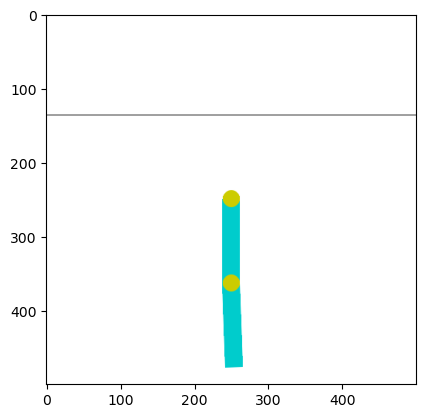

In [45]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

# Building the network for Policy Gradient (REINFORCE)

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [47]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [48]:
# Build a simple neural network that predicts policy logits.
# Keep it simple: CartPole isn't worth deep architectures.

model = DQN(state_dim[0], n_actions)
assert model is not None, "model is not defined"

In [49]:
# do not change the code block below
batch_size_for_test = 5
example_states_batch = np.array([env.reset()[0] for _ in range(5)])
print(f"example_states_batch.shape: {example_states_batch.shape}")
assert example_states_batch.shape == (batch_size_for_test, state_dim[0])

example_logits = model(torch.from_numpy(example_states_batch))
print(f"example_logits.shape: {example_logits.shape}")
assert example_logits.shape == (batch_size_for_test, n_actions)
# do not change the code block above

example_states_batch.shape: (5, 6)
example_logits.shape: torch.Size([5, 3])


#### Predicting the action probas

Note: **output value of this function is not a torch tensor, it's a numpy array.**

So, here gradient calculation is not needed.

Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.

Also, `.detach()` can be used instead, but there is a difference:

* With `.detach()` computational graph is built but then disconnected from a particular tensor, so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
* In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [50]:
def predict_probs(states, model):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability

    # YOUR CODE GOES HERE

    with torch.no_grad():
        states = torch.from_numpy(states).float()
        logits = model(states)
        probs = nn.functional.softmax(logits, dim=1).numpy()
    assert probs is not None, "probs is not defined"

    return probs

In [51]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states, model)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [52]:
def generate_session(env, t_max=5000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s, info = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]), model)[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, truncated, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [53]:
# test it
states, actions, rewards = generate_session(env)
print(states, actions, rewards)

[array([ 9.9635428e-01, -8.5311905e-02,  9.9969876e-01, -2.4543799e-02,
       -8.3517671e-02,  8.5999997e-04], dtype=float32), array([ 0.995815  , -0.09139193,  0.9995429 , -0.03023338,  0.02342534,
       -0.05757824], dtype=float32), array([ 0.99707097, -0.07648209,  0.9989188 , -0.04649014,  0.12257449,
       -0.0998654 ], dtype=float32), array([ 0.99899894, -0.0447337 ,  0.9977395 , -0.06720023,  0.18836094,
       -0.09900641], dtype=float32), array([ 0.9999624 ,  0.00867404,  0.99321467, -0.11629517,  0.33325806,
       -0.376767  ], dtype=float32), array([ 0.9984497 ,  0.05566199,  0.990194  , -0.13969879,  0.12696478,
        0.15127964], dtype=float32), array([ 0.9983409 ,  0.05758021,  0.9984124 , -0.05632705, -0.10540321,
        0.6723389 ], dtype=float32), array([ 0.9998558 ,  0.01697992,  0.9930354 ,  0.11781632, -0.28633952,
        1.0343031 ], dtype=float32), array([ 0.9987918 , -0.04914123,  0.9432171 ,  0.33217692, -0.3540042 ,
        1.1216477 ], dtype=float32), 

### Computing cumulative rewards

To work with sequential environments we need the cumulative discounted reward for known for every state. To compute it we can **roll back** from the end of the session to the beginning and compute the discounted cumulative reward as following:

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [54]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    # YOUR CODE GOES HERE
    cumulative_rewards = []
    g = 0
    for r in rewards[::-1]:
        g = g * gamma + r
        cumulative_rewards.append(g)

    cumulative_rewards.reverse()

    assert cumulative_rewards is not None, "cumulative_rewards is not defined"

    return cumulative_rewards

In [55]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

Final loss should also include the entropy regularization term $H(\pi_\theta (a_i \mid s_i))$ to enforce the exploration:

$$
L = -\hat J(\theta) - \lambda H(\pi_\theta (a_i \mid s_i)),
$$
where $\lambda$ is the `entropy_coef`. 

This function might be useful:

In [56]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [57]:
def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute the loss for the REINFORCE algorithm.
    """
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    probs = nn.functional.softmax(logits, dim=1)
    assert probs is not None, "probs is not defined"

    log_probs = nn.functional.log_softmax(logits, dim=1)
    assert log_probs is not None, "log_probs is not defined"

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(log_probs * to_one_hot(actions, n_actions), dim=1)
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    J_hat = torch.mean(log_probs_for_actions * cumulative_returns)
    assert J_hat is not None, "J_hat is not defined"
    
    # Compute loss here. Don't forget entropy regularization with `entropy_coef`
    entropy = -torch.sum(probs * log_probs, dim=1).mean()
    assert entropy is not None, "entropy is not defined"
    loss = -J_hat - entropy_coef * entropy
    assert loss is not None, "loss is not defined"

    return loss

In [58]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    states = torch.tensor(states, dtype=torch.float32)
    logits = model(states)
    # cast everything into torch tensors
    loss = get_loss(logits, actions, rewards, n_actions=n_actions, gamma=gamma, entropy_coef=entropy_coef)
    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(500):
    rewards = [train_on_session(*generate_session(env), entropy_coef=1e-3) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > -100:
        print("You Win!")  # but you can train even further
        break

mean reward:-1000.000


### Watch the video of your results:

In [17]:
import os
import numpy as np
import gymnasium as gym
from gymnasium.utils.save_video import save_video
from moviepy.config import change_settings
change_settings({"FFMPEG_BINARY": r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"})

env_for_video = gym.make("CartPole-v1", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

obs, info = env_for_video.reset()

for step_index in range(800):
    probs = predict_probs(np.array([obs]), model)[0]
    action = np.random.choice(n_actions, p=probs)

    obs, reward, terminated, truncated, info = env_for_video.step(action)
    done = terminated or truncated

    if done or step_index == 799:
        # env_for_video.render() now returns the LIST of frames accumulated so far
        frames = env_for_video.render()
        os.makedirs("videos", exist_ok=True)
        save_video(
            frames, "videos",
            fps=env_for_video.metadata.get("render_fps", 30),
            step_starting_index=step_starting_index,
            episode_index=episode_index,
        )
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()

env_for_video.close()


Moviepy - Building video E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-0.mp4.
Moviepy - Writing video E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-0.mp4
Moviepy - Building video E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-1.mp4.
Moviepy - Writing video E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready E:\Coding\girafe-ai\ml-course\homeworks\hw04_policy_gradient\videos/rl-video-episode-1.mp4


Congratulations! Finally, copy the `predict_probs`, `get_cumulative_rewards` and `get_loss` to the template and submit them to the Contest.

Good luck!

## Bonus part (no points, just for the interested ones)

Try solving the `Acrobot-v1` environment. It is more complex than regular `CartPole-v1`, so the default Policy Gradient (REINFORCE) algorithm might not work. Maybe the baseline idea could help...

![Acrobot](https://gymnasium.farama.org/_images/acrobot.gif)
